In [37]:
# LSTM for international airline passengers problem with regression framing
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.metrics import MeanAbsoluteError,RootMeanSquaredError

In [39]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
tf.random.set_seed(7)
# load the dataset
dataframe = read_csv('data/BTC-all.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(150, return_sequences=True, activation='relu', input_shape=(1, look_back)))
model.add(LSTM(150, activation='relu', input_shape=(1, look_back)))
model.add(Dense(150))
model.add(Dense(1))



early_stopping = EarlyStopping(monitor='val_loss',patience=3,mode='min')

model.compile(loss='mean_squared_error', optimizer='adam',metrics=[MeanAbsoluteError()])
model.fit(trainX, trainY, epochs=100, batch_size=64,callbacks=[early_stopping]
	  )
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Epoch 1/100
45/45 [==============================] - 3s 12ms/step - loss: 0.0428 - mean_absolute_error: 0.1491
Epoch 2/100
45/45 [==============================] - 1s 11ms/step - loss: 8.1766e-04 - mean_absolute_error: 0.0196
Epoch 3/100
45/45 [==============================] - 0s 10ms/step - loss: 1.6509e-04 - mean_absolute_error: 0.0069
Epoch 4/100
45/45 [==============================] - 0s 11ms/step - loss: 1.5306e-04 - mean_absolute_error: 0.0065
Epoch 5/100
45/45 [==============================] - 0s 9ms/step - loss: 1.5415e-04 - mean_absolute_error: 0.0063
Epoch 6/100
45/45 [==============================] - 0s 9ms/step - loss: 1.6001e-04 - mean_absolute_error: 0.0069
Epoch 7/100
10/10 [==============================] - 0s 3ms/step
Train Score: 928.95 RMSE
Test Score: 848.10 RMSE


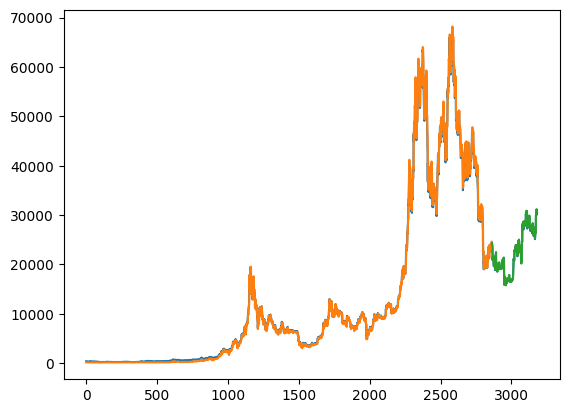

In [28]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()